In [1]:
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import bottleneck
import numpy as np
import subprocess as sp
import os
import glob
import cartopy.crs as ccrs
import cftime

In [2]:
def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(1,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(2,nxp+1,2),nyp=slice(2,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(1,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid


In [3]:


#Note that parent grid uv values are symmetric
path_parent_grid='/home/nma/HDD_data/vinay/archives/IOMOM5Op/MOM4p1.nc'
parent_grid=open_grid(path_parent_grid)
path_regional_grid="/home/nma/mom/MOM6dev/exps/2012_bob_obc/INPUT/horizontal_grid.nc"
regional_grid=open_grid(path_regional_grid)

parent_grid

{'ds': <xarray.Dataset>
 Dimensions:   (nyp: 481, nxp: 721)
 Dimensions without coordinates: nyp, nxp
 Data variables:
     x         (nyp, nxp) float64 ...
     y         (nyp, nxp) float64 ...
     angle_dx  (nyp, nxp) float64 ...
     arcx      |S255 ...
 Attributes:
     grid_version:  0.2
     code_version:  $Name: fre-nctools-bronx-10 $
     history:       make_hgrid --grid_type regular_lonlat_grid --nxbnd 2 --nyb...,
 'nyp': 481,
 'nxp': 721,
 'h': <xarray.Dataset>
 Dimensions:   (nyp: 240, nxp: 360)
 Dimensions without coordinates: nyp, nxp
 Data variables:
     x         (nyp, nxp) float64 ...
     y         (nyp, nxp) float64 ...
     angle_dx  (nyp, nxp) float64 ...
     arcx      |S255 ...
 Attributes:
     grid_version:  0.2
     code_version:  $Name: fre-nctools-bronx-10 $
     history:       make_hgrid --grid_type regular_lonlat_grid --nxbnd 2 --nyb...,
 'q': <xarray.Dataset>
 Dimensions:   (nyp: 240, nxp: 360)
 Dimensions without coordinates: nyp, nxp
 Data variables:
 

### Merging all dataset

In [4]:
os.chdir("/home/nma/HDD_data/vinay/archives/IOMOM5Op/")

uu = xr.open_mfdataset("*.ocean_uvel.nc")
vv = xr.open_mfdataset("*.ocean_vvel.nc")
salt = xr.open_mfdataset("*.ocean_salt.nc")
ssh = xr.open_mfdataset("*.ocean_diag.nc").eta_t
temp = xr.open_mfdataset("*.ocean_temp.nc")
grd_p = "/home/nma/mom/MOM6dev/exps/2012_bob_obc/INPUT/horizontal_grid.nc"
#grd_p = "/home/nma/mom/MOM6dev/prepro/obc/obcmar/20120101.ocean_sfc.nc"
grid = xr.open_dataset(grd_p)
sam_op = xr.open_dataset("/home/nma/HDD_data/vinay/archives/finals/20130101.ocean_sfc.nc")

ds = xr.merge([uu,vv,salt,ssh,temp])
startslice = cftime.DatetimeNoLeap(2012, 1, 1,0,0,0,0,-1,1)
endslice = cftime.DatetimeNoLeap(2014, 1, 1,0,0,0,0,-1,1)

ds_cut = ds.sel(time=slice(startslice,endslice))

ds_cut


<xarray.Dataset>
Dimensions:         (xu_ocean: 360, yu_ocean: 240, st_ocean: 58, st_edges_ocean: 59, time: 730, nv: 2, xt_ocean: 360, yt_ocean: 240)
Coordinates:
  * xu_ocean        (xu_ocean) float64 30.12 30.38 30.62 ... 119.4 119.6 119.9
  * yu_ocean        (yu_ocean) float64 -29.88 -29.62 -29.38 ... 29.62 29.88
  * st_ocean        (st_ocean) float64 0.5 1.5 2.5 ... 3.625e+03 4.3e+03 5e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.0 2.0 ... 4.65e+03 5.35e+03
  * time            (time) object 2012-01-01 12:00:00 ... 2013-12-31 12:00:00
  * nv              (nv) float64 1.0 2.0
  * xt_ocean        (xt_ocean) float64 30.0 30.25 30.5 ... 119.2 119.5 119.8
  * yt_ocean        (yt_ocean) float64 -30.0 -29.75 -29.5 ... 29.25 29.5 29.75
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(92, 58, 240, 360), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(92,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(92,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(92,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(92, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(92, 58, 240, 360), meta=np.ndarray>
    salt            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(92, 58, 240, 360), meta=np.ndarray>
    eta_t           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(92, 240, 360), meta=np.ndarray>
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(92, 58, 240, 360), meta=np.ndarray>
Attributes:
    filename:   ocean_uvel.nc
    title:      IOMV6d : Inter-annual  QuikSCAT Run
    grid_type:  regular
    grid_tile:  N/A



# Open parent model data and merge respective grids

In [5]:


def open_dataset(path,fields,grid):
    #ds=xr.open_dataset(path,decode_times=False)
    ds = path
    tracer_list=[];uv_list=[]
    for f in fields:
        for fnam,val in zip(f.keys(),f.values()):
            if val=='h':tracer_list.append(fnam)
            if val=='Cu':uv_list.append(fnam)
            if val=='Cv':uv_list.append(fnam)
                
    ds_tr = xr.merge([ds, grid['h']])
    ds_u= xr.merge([ds,grid['Cu']])
    ds_v= xr.merge([ds,grid['Cv']])
    return {'ds_tr':ds_tr,'ds_u':ds_u,'ds_v':ds_v,'tracers':tracer_list,'uv':uv_list}



In [7]:


#path_model_data='../data/20120101.ocean_month.nc'
init_model_data = ds_cut
fields=[{'temp':'h'},{'salt':'h'},{'eta_t':'h'},{'u':'Cu'},{'v':'Cv'}]
model_data = open_dataset(init_model_data,fields,parent_grid)



## Remap velocities

In [8]:
def velocity_at_corners(ds_u,ds_v):
    nxp=ds_u.nxp[-1].data+1;nyp=ds_v.nyp[-1].data+1
    #upper-right q points
    u_q=0.5*(ds_u.u+ds_u.u.roll(roll_coords='yh',yu_ocean=-1)).isel(xu_ocean=slice(1,nxp))
    #upper-right q points
    v_q=0.5*(ds_v.v+ds_v.v.roll(roll_coords='xh',xu_ocean=-1)).isel(yu_ocean=slice(1,nyp))
    ds_uvq = xr.Dataset({'u':u_q,'v':v_q},coords={'time':ds_u.time,'lon':parent_grid['q'].x,'lat':parent_grid['q'].y,'angle_dx':parent_grid['q'].angle_dx})
    return ds_uvq

In [9]:

ds_u=model_data['ds_u'];ds_v=model_data['ds_v']
model_data['ds_uv']=velocity_at_corners(ds_u.isel(time=slice(0,1)),ds_v.isel(time=slice(0,1)))

model_data['ds_uv']

<xarray.Dataset>
Dimensions:   (yu_ocean: 240, xu_ocean: 360, st_ocean: 58, time: 1, nyp: 240, nxp: 360)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -29.88 -29.62 -29.38 ... 29.38 29.62 29.88
  * xu_ocean  (xu_ocean) float64 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * st_ocean  (st_ocean) float64 0.5 1.5 2.5 3.5 ... 3.625e+03 4.3e+03 5e+03
  * time      (time) object 2012-01-01 12:00:00
    lon       (nyp, nxp) float64 ...
    lat       (nyp, nxp) float64 ...
    angle_dx  (nyp, nxp) float64 ...
Dimensions without coordinates: nyp, nxp
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 58, 240, 360), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 58, 240, 360), meta=np.ndarray>

In [10]:


def apply_rotation(u,v,angle_dx,time_slice=slice(0)):
    """Rotate from model space to easterly coordinates"""
    deg_rad=np.pi/180.    
    
    if time_slice is not None:
        t=u.time.isel(time=time_slice)
    else:
        t=u.time
        
    if time_slice is not None:
        ue=np.cos(angle_dx.data*deg_rad)*u.isel(time=time_slice).data-np.sin(angle_dx.data*deg_rad)*v.isel(time=time_slice).data
        vn=np.sin(angle_dx.data*deg_rad)*u.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*v.isel(time=time_slice).data  
    else:
        ue=np.cos(angle_dx.data*deg_rad)*u.data-np.sin(angle_dx.data*deg_rad)*v.data
        vn=np.sin(angle_dx.data*deg_rad)*u.data+np.cos(angle_dx.data*deg_rad)*v.data  
        
    us=ue.shape
    nyp=us[2];nxp=us[3]
    ue=xr.DataArray(ue,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.st_ocean.data},dims=('time','z_l','j','i'))
    vn=xr.DataArray(vn,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.st_ocean.data},dims=('time','z_l','j','i'))
        

    return ue,vn



In [11]:
def apply_rotation_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))


        
    return u,v

In [12]:


ds_uvq=model_data['ds_uv']
uq_rot,vq_rot= apply_rotation(ds_uvq.u,ds_uvq.v,ds_uvq.angle_dx,time_slice=None)
ds_uvq_r = xr.Dataset({'u':uq_rot,'v':vq_rot},coords={'time':ds_uvq.time,'lon':ds_uvq.lon,'lat':ds_uvq.lat})
model_data['ds_uv_r']=ds_uvq_r

ds_uvq

<xarray.Dataset>
Dimensions:   (yu_ocean: 240, xu_ocean: 360, st_ocean: 58, time: 1, nyp: 240, nxp: 360)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -29.88 -29.62 -29.38 ... 29.38 29.62 29.88
  * xu_ocean  (xu_ocean) float64 30.12 30.38 30.62 30.88 ... 119.4 119.6 119.9
  * st_ocean  (st_ocean) float64 0.5 1.5 2.5 3.5 ... 3.625e+03 4.3e+03 5e+03
  * time      (time) object 2012-01-01 12:00:00
    lon       (nyp, nxp) float64 30.25 30.5 30.75 31.0 ... 119.3 119.6 119.8
    lat       (nyp, nxp) float64 -29.75 -29.75 -29.75 ... 29.75 29.75 29.75
    angle_dx  (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: nyp, nxp
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 58, 240, 360), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 58, 240, 360), meta=np.ndarray>

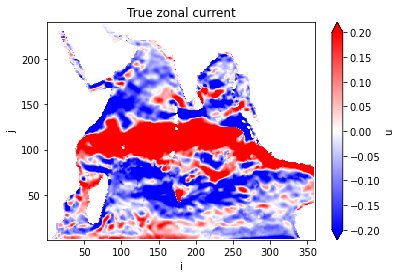

In [13]:
ds_uvq_r.u.isel(z_l=0).plot(vmin=-.2,vmax=.2,cmap='bwr')
title=plt.title('True zonal current')

In [14]:
def uvmag(u,v,z_slice=0):
    spd=np.sqrt(np.squeeze(u.isel(z_l=z_slice).data**2.0 + v.isel(z_l=z_slice).data**2))
    return xr.DataArray(spd,coords={'i':u.i.data,'j':u.j.data},dims=('j','i'))

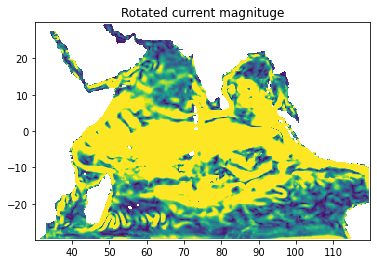

In [15]:
uvmag_r = uvmag(ds_uvq_r.u,ds_uvq_r.v)
plt.pcolormesh(parent_grid['q'].x,parent_grid['q'].y,uvmag_r.data,vmin=0.001,vmax=0.2)

title=plt.title('Rotated current magnituge')

In [16]:


ds_regional=regional_grid['ds']


# southern boundary
south = xr.Dataset()
south['lon'] = ds_regional['x'].isel(nyp=0)
south['lat'] = ds_regional['y'].isel(nyp=0)

# western boundary
west = xr.Dataset()
west['lon'] = ds_regional['x'].isel(nxp=0)
west['lat'] = ds_regional['y'].isel(nxp=0)



In [21]:
ds_tr=model_data['ds_tr']
ds_tr = xr.Dataset({'temp':ds_tr.temp,'salt':ds_tr.salt},coords={'lon':ds_tr.x,'lat':ds_tr.y})

ds

<xarray.Dataset>
Dimensions:         (xu_ocean: 360, yu_ocean: 240, st_ocean: 58, st_edges_ocean: 59, time: 2217, nv: 2, xt_ocean: 360, yt_ocean: 240)
Coordinates:
  * xu_ocean        (xu_ocean) float64 30.12 30.38 30.62 ... 119.4 119.6 119.9
  * yu_ocean        (yu_ocean) float64 -29.88 -29.62 -29.38 ... 29.62 29.88
  * st_ocean        (st_ocean) float64 0.5 1.5 2.5 ... 3.625e+03 4.3e+03 5e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.0 2.0 ... 4.65e+03 5.35e+03
  * time            (time) object 2009-04-03 12:00:00 ... 2015-04-29 12:00:00
  * nv              (nv) float64 1.0 2.0
  * xt_ocean        (xt_ocean) float64 30.0 30.25 30.5 ... 119.2 119.5 119.8
  * yt_ocean        (yt_ocean) float64 -30.0 -29.75 -29.5 ... 29.25 29.5 29.75
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1095, 58, 240, 360), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(1095,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(1095,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(1095,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(1095, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1095, 58, 240, 360), meta=np.ndarray>
    salt            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1095, 58, 240, 360), meta=np.ndarray>
    eta_t           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1095, 240, 360), meta=np.ndarray>
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1095, 58, 240, 360), meta=np.ndarray>
Attributes:
    filename:   ocean_uvel.nc
    title:      IOMV6d : Inter-annual  QuikSCAT Run
    grid_type:  regular
    grid_tile:  N/A

In [18]:



regrid_south_uv = xesmf.Regridder(ds_uvq_r, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_uv.nc')

regrid_west_uv = xesmf.Regridder(ds_uvq_r, west, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_west_uv.nc')



In [19]:



regrid_south_tr = xesmf.Regridder(ds_tr, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_tr.nc')
regrid_west_tr = xesmf.Regridder(ds_tr, west, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_west_tr.nc')

ntime=ds_tr.temp.shape[0]
ntime = 5
ntime = 1 
ntime

1

In [22]:

for i in range(ntime):
    print(i)
    uq_rot,vq_rot= apply_rotation(ds_uvq.u,ds_uvq.v,ds_uvq.angle_dx,time_slice=slice(i,i+1))
    ds_uvq_r = xr.Dataset({'u':uq_rot,'v':vq_rot},coords={'lon':ds_uvq.lon,'lat':ds_uvq.lat})
    
    u_south_r = regrid_south_uv(ds_uvq_r['u'])
    v_south_r = regrid_south_uv(ds_uvq_r['v'])
    u_west_r = regrid_west_uv(ds_uvq_r['u'])
    v_west_r = regrid_west_uv(ds_uvq_r['v'])
    
    u_south,v_south=apply_rotation_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)
    ds_uv_south = xr.Dataset({'u':u_south,'v':v_south},coords={'lon':south.lon,'lat':south.lat,'z_l':ds_uvq.st_ocean})
    fnam='uv_south_'+str(i).zfill(2)+'.nc'
    ds_uv_south.to_netcdf(fnam,format='NETCDF3_CLASSIC')
    
    
    u_west,v_west=apply_rotation_transpose(u_west_r,v_west_r,ds_regional.angle_dx.isel(nxp=ds_regional.nxp[0]),time_slice=None)
    ds_uv_west = xr.Dataset({'u':u_west,'v':v_west},coords={'lon':west.lon,'lat':west.lat,'z_l':ds_uvq.st_ocean})
    fnam='uv_west_'+str(i).zfill(2)+'.nc'
    ds_uv_west.to_netcdf(fnam,format='NETCDF3_CLASSIC')

0


/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j', 'i') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j', 'i') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(
/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j', 'i') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


In [24]:
os.chdir("/home/nma/mom/MOM6dev/prepro/obc/obcflather/")

uq_rot,vq_rot= apply_rotation(ds_uvq.u,ds_uvq.v,ds_uvq.angle_dx,time_slice=slice(1))
ds_uvq_r = xr.Dataset({'u':uq_rot,'v':vq_rot},coords={'lon':ds_uvq.lon,'lat':ds_uvq.lat})

u_south_r = regrid_south_uv(ds_uvq_r['u'])
v_south_r = regrid_south_uv(ds_uvq_r['v'])
u_west_r = regrid_west_uv(ds_uvq_r['u'])
v_west_r = regrid_west_uv(ds_uvq_r['v'])

u_south,v_south=apply_rotation_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)
ds_uv_south = xr.Dataset({'u':u_south,'v':v_south},coords={'lon':south.lon,'lat':south.lat,'z_l':ds_uvq.st_ocean})
fnam='uv_south_'+str(1).zfill(2)+'.nc'
ds_uv_south.to_netcdf(fnam,format='NETCDF3_CLASSIC')

/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j', 'i') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j', 'i') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(
